#### Multiclass Classification of J Gene Type

In [1]:
cd ..

/home/romi/projects/preTCR


In [4]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os, sys
import collections
import lab_notebooks.utils
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
from matplotlib.colors import ListedColormap
import seaborn as sns
import torch

SRC_DIR = "cvc"
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
from cvc import model_utils
from cvc import plot_utils
from lab_notebooks.utils import TRANSFORMER, DEVICE, DATA_DIR
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/CDR3_data_plots")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

#### Load Data

In [6]:
gene_type = 'V' #'J'
load_csv = False

In [78]:
if gene_type == 'J':
    data_dir = DATA_DIR + "j_gene_embeddings.csv"
    data_dir_full = DATA_DIR + 'jgene_embed_full_data.csv'
    gene_column = 'jGeneName'
    output_path = './jgene_data_embeddings_with_label_and_sequence.csv'
    input_path = './jgene_data_embeddings_with_label_and_sequence.csv'
else:
    data_dir = DATA_DIR + "v_gene_embeddings.csv"
    data_dir_full = DATA_DIR + 'vgene_public_specific_data.csv'
        #'vgene_data_classfy1.csv' #vgene_embed_full_data.csv'
    gene_column = 'vGeneName'
    output_path = './vgene_public_specific_data_embeddings_with_label_and_sequence.csv'
    input_path = './vgene_data_embeddings_with_label_and_sequence.csv'

In [79]:
# read data
gene_data = pd.read_csv(data_dir_full, engine="pyarrow")

In [80]:
gene_data = gene_data[['Sequences', 'Appearances', 'Private_Public_label', gene_column]]
gene_data

,Sequences,Appearances,Private_Public_label,vGeneName
0,CASSSDRRFYEQYF,1,0,TCRBV19-01
1,CASSIATASGRDTQYF,1,0,TCRBV19-01
2,CASSPLGGLGQYF,2,1,TCRBV19-01
3,CASSIVWGSIGRGGNIQYF,1,0,TCRBV19-01
4,CASSDGGTGSNEQFF,1,0,TCRBV19-01
...,...,...,...,...
1384997,CATSDSDRGSYGYTF,1,0,TCRBV24-01
1384998,CATSDVVPGPTYNEQFF,1,0,TCRBV24-01
1384999,CATSGSLAGVLHEQFF,1,0,TCRBV24-01
1385000,CATSDYGSGPSSYNEQFF,1,0,TCRBV24-01


In [81]:
collections.Counter(gene_data['Private_Public_label'])

Counter({0: 1161620, 1: 223382})

In [82]:
collections.Counter(gene_data[gene_column])

Counter({'TCRBV19-01': 406807,
         'TCRBV18-01': 190883,
         'TCRBV30-01': 192778,
         'TCRBV10-03': 142143,
         'TCRBV29-01': 168280,
         'TCRBV15-01': 99014,
         'TCRBV20-01': 67626,
         'TCRBV24-01': 117471})

#### Create subset with equall distribution of genes

In [83]:
# extract sequences that do not have *
gene_data_to_use = [seq for seq in gene_data['Sequences'] if '*' not in seq]
len(gene_data_to_use)

1360388

In [84]:
gene_data_edit = gene_data

In [85]:
# leave the sequences that do not have *
gene_data_edit = gene_data_edit.loc[gene_data_edit['Sequences'].isin(gene_data_to_use)]
len(gene_data_edit)

1360388

In [87]:
# convert label column to numpy array
gene_label_array = gene_data_edit[gene_column].to_numpy()
print(gene_label_array)

['TCRBV19-01' 'TCRBV19-01' 'TCRBV19-01' ... 'TCRBV24-01' 'TCRBV24-01'
 'TCRBV24-01']


In [88]:
collections.Counter(gene_data_edit[gene_column])

Counter({'TCRBV19-01': 400981,
         'TCRBV18-01': 188530,
         'TCRBV30-01': 189746,
         'TCRBV10-03': 139682,
         'TCRBV29-01': 165929,
         'TCRBV15-01': 97256,
         'TCRBV20-01': 66628,
         'TCRBV24-01': 111636})

In [ ]:
# get minimum count
min_value = min(collections.Counter(gene_data_edit[gene_column]).values())
# sample from each group according to minimum count
sampled_data = gene_data_edit.groupby(gene_column, sort=False).apply(lambda x: x.sample(min_value))
sampled_data

In [91]:
collections.Counter(sampled_data[gene_column])

Counter({'TCRBV19-01': 66628,
         'TCRBV18-01': 66628,
         'TCRBV30-01': 66628,
         'TCRBV10-03': 66628,
         'TCRBV29-01': 66628,
         'TCRBV15-01': 66628,
         'TCRBV20-01': 66628,
         'TCRBV24-01': 66628})

#### Embeddings

In [ ]:
from cvc.embbeding_wrapper import EmbeddingWrapper

# Create embeddings
embed_wrap = EmbeddingWrapper(TRANSFORMER, DEVICE, sampled_data, batch_size=1024, method="mean", layers=[-1])
embed_wrap.embeddings.shape

In [94]:
# create anndata object
tcrb_embeddings_adata = embed_wrap.create_anndata()
tcrb_embeddings_adata

AnnData object with n_obs × n_vars = 533024 × 768
    obs: 'Sequences', 'Appearances', 'Private_Public_label', 'vGeneName'

In [95]:
df_embeddings = pd.DataFrame(embed_wrap.embeddings)
df_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.267327,0.378248,0.212134,-0.538438,0.355222,-0.049650,-0.138501,0.578286,0.074364,-0.053236,...,-0.833294,-0.918703,0.681873,-0.609621,-0.623982,-0.272287,-0.084609,0.488079,-0.270363,-0.395688
1,-0.180929,0.031371,-0.977410,-0.293124,0.171839,0.245886,-0.270421,0.034842,0.068647,-0.125348,...,-0.133794,0.125169,-0.062554,0.520991,0.069077,0.673374,-0.541676,0.782637,0.367026,0.672535
2,-0.099687,0.121359,-1.004811,-0.101787,0.072440,-0.164602,0.270649,0.090114,0.317392,-0.349951,...,0.310287,0.066215,-0.188149,0.338994,-0.002995,0.622127,-0.436129,0.443981,0.401201,0.402440
3,-0.087060,0.318789,-0.888871,-0.249198,0.018457,0.082617,-0.217170,0.245869,0.072656,-0.452326,...,-0.002164,-0.327957,-0.010220,0.226084,-0.321754,0.696947,-0.525875,0.377622,0.650951,-0.095232
4,-0.250581,0.336046,0.039553,-0.635242,0.352109,0.034677,0.361312,-0.087486,0.084265,-0.604619,...,-0.060031,-0.488144,0.238013,-0.191540,-0.214597,0.201849,-0.138888,0.780076,0.451069,0.325339


In [96]:
# add gene label to dataframe
df_embeddings_with_label = df_embeddings
df_embeddings_with_label[gene_column]=list(tcrb_embeddings_adata.obs[gene_column])
df_embeddings_with_label['Sequences']=list(tcrb_embeddings_adata.obs['Sequences'])

In [97]:
# export embeddings to csvֿ
df_embeddings_with_label.to_csv(output_path)

In [31]:
# # load from csv
if load_csv==True:
    df_embeddings_with_label = pd.read_csv(input_path)
    tcrb_embeddings = df_embeddings_with_label.iloc[:,1:-2].to_numpy()
    j_gene_array = df_embeddings_with_label.iloc[:,-2].to_numpy()

#### Classification Utils

In [98]:
accuracy_dictionary = {}

In [99]:
TRAIN_RATIO = 0.8
def split_train_test(embeddings, embedding_labels):
    # The data will be divided into 80% training 20% validation
    idx_train = int(len(embeddings) * TRAIN_RATIO)

    indices = np.arange(embeddings.shape[0])
    # Shuffle data
    np.random.shuffle(indices)

    # Separate the images and the labels
    embeddings_shuffle = embeddings[indices] 
    embedding_labels_shuffle = embedding_labels[indices]

    # Split to train and validation
    train_embeddings = embeddings_shuffle[:idx_train]
    train_labels = embedding_labels_shuffle[:idx_train]
    validation_embeddings = embeddings_shuffle[idx_train:]
    validation_labels = embedding_labels_shuffle[idx_train:]
    
    return train_embeddings, train_labels, validation_embeddings, validation_labels

In [100]:
# run if data was read from a csv
if load_csv==True:
    embeddings = tcrb_embeddings
    embedding_labels = df_embeddings_with_label[gene_column]
    print("shape of embeddings: {}\nshape of embedding_labels: {}".format(embeddings.shape,embedding_labels.shape))

shape of embeddings: (533024, 768)
shape of embedding_labels: (533024,)


In [102]:
train_embeddings, embed_train_labels, validation_embeddings, embed_validation_labels = split_train_test(embeddings, embedding_labels)
train_embeddings.shape, embed_train_labels.shape, validation_embeddings.shape, embed_validation_labels.shape

((426419, 768), (426419,), (106605, 768), (106605,))

In [103]:
# check for even distribution
collections.Counter(embed_validation_labels), collections.Counter(embed_train_labels)

(Counter({'TCRBV20-01': 13485,
          'TCRBV15-01': 13485,
          'TCRBV19-01': 13377,
          'TCRBV24-01': 13141,
          'TCRBV30-01': 13192,
          'TCRBV10-03': 13354,
          'TCRBV18-01': 13244,
          'TCRBV29-01': 13327}),
 Counter({'TCRBV10-03': 53274,
          'TCRBV18-01': 53384,
          'TCRBV20-01': 53143,
          'TCRBV30-01': 53436,
          'TCRBV15-01': 53143,
          'TCRBV19-01': 53251,
          'TCRBV24-01': 53487,
          'TCRBV29-01': 53301}))

In [104]:
# convert string to integer
def genes_to_num(labels):
    labels_unique = np.unique(labels)
    labels_to_num = pd.factorize(labels_unique)
    return labels_to_num

In [105]:
genes_int_ratio = genes_to_num(embed_train_labels)
# make dictionary of gene to integer
gene_to_num_dictionary = dict(zip(genes_int_ratio[1], genes_int_ratio[0]))
# convert embed_train_labels to integer using dictionary
embed_train_labels_num = [gene_to_num_dictionary[gene] for gene in embed_train_labels]
embed_val_labels_num = [gene_to_num_dictionary[gene] for gene in embed_validation_labels]

#### xgBoost on Embeddings
Guide on xgBoost - https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390


In [40]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_embeddings = sc.fit_transform(train_embeddings)
validation_embeddings = sc.fit_transform(validation_embeddings)

In [ ]:
# extract accuracy
accuracy_dictionary['xgBoost'], xgb_preds, xgb_classifier = \
    lab_notebooks.utils.xgb_classify(train_embeddings, embed_train_labels_num, validation_embeddings, embed_val_labels_num)

In [ ]:
# if PLOT_J_GENE is 1 then the umap will be colored by the J genes, otherwise it will be colored by the private/public label
PLOT_J_GENE = 1
if gene_type=='J':
    if PLOT_J_GENE==1:
        color_label='jGeneName',
        direct_label=False,
        color_map = ListedColormap(sns.color_palette("Spectral", 13))
        cmap= color_map,
        title="UMAP of Embeddings, Colored by J Genes",
        legend_size=4,
        pdf_title="tcr_model_db_data_umap_j_genes.pdf",
    else:
        color_label='Private_Public_label',
        direct_label=False,
        colors = ['gold', 'darkblue']
        cmap=matplotlib.colors.ListedColormap(colors),
        title="UMAP of Embeddings, Colored by Public/Private Label",
        legend_size=4,
        pdf_title="tcr_model_db_data_umap_j_genes.pdf",

# Plot embeddings
embed_wrap.plot_embedding(
    anndata=tcrb_embeddings_adata,
    color_embed=color_label,
    color_map=cmap,
    title=title,
    legend_size=legend_size,
    plot_pdf_path=os.path.join(PLOT_DIR, pdf_title),
)

#### One-Hot Encoding

In [115]:
# Import Dependencies 
import pandas as pd
import numpy as np

# Function to encode sequences
def encode_seq(sequence, max_cdr3_len):
    alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    integer_encoded = [char_to_int[char] for char in sequence]
    
    # one hot encode
    integer_encoded = torch.tensor(integer_encoded)
    integer_encoded = F.one_hot(integer_encoded, num_classes=len(alphabet))
    
    # pad integer_encoded tensor first dim with zeros up to max_cdr3_len
    integer_encoded = F.pad(integer_encoded, (0,0,0, max_cdr3_len - len(integer_encoded)))
    integer_encoded = integer_encoded.numpy()
    return integer_encoded

In [116]:
# extract sequences
cdr3_sequences = df_embeddings_with_label['Sequences']#tcrb_data_sample['Sequences']
sequences_labels = df_embeddings_with_label[gene_column]
max_cdr3_len = cdr3_sequences.apply(len).max()
max_cdr3_len

27

In [117]:
# split data into train/test
train_seqs, train_labels, validation_seqs, validation_labels = split_train_test(cdr3_sequences.to_numpy(), sequences_labels)
print("shape of training set: {}\nshape of validation set: {}".format(train_seqs.shape, validation_seqs.shape))

shape of training set: (426419,)
shape of validation set: (106605,)


In [118]:
# encode amino acid sequences to one hot vector
encoded_train_seqs = pd.Series(train_seqs).apply(lambda x: encode_seq(x, max_cdr3_len))
encoded_validation_seqs = pd.Series(validation_seqs).apply(lambda x: encode_seq(x, max_cdr3_len))

In [120]:
# Stack list(encoded_train_seqs) in dim 0
train_seqs_stack = np.stack(encoded_train_seqs, axis=0)
valid_seqs_stack = np.stack(encoded_validation_seqs, axis=0)
train_seqs_stack.shape, valid_seqs_stack.shape

((426419, 27, 20), (106605, 27, 20))

In [121]:
# reshape train/validation tensors
train_seqs_stack = train_seqs_stack.reshape(train_seqs_stack.shape[0], -1)
valid_seqs_stack = valid_seqs_stack.reshape(valid_seqs_stack.shape[0], -1)
train_seqs_stack.shape, valid_seqs_stack.shape

((426419, 540), (106605, 540))

In [122]:
genes_int_ratio = genes_to_num(train_labels)
# make dictionary of gene to integer
gene_to_num_dictionary = dict(zip(genes_int_ratio[1], genes_int_ratio[0]))
# convert embed_train_labels to integer using dictionary
train_labels_num = [gene_to_num_dictionary[gene] for gene in train_labels]
val_labels_num = [gene_to_num_dictionary[gene] for gene in validation_labels]

#### xgBoost on One-Hot Encoding

In [ ]:
# apply xgb on onehot, extract accuracy
accuracy_dictionary['xgBoost_OneHot'], xgb_preds_onehot, xgb_classifier_onehot =\
    lab_notebooks.utils.xgb_classify(train_seqs_stack, train_labels_num, valid_seqs_stack, val_labels_num)

### LDA

In [ ]:
accuracy_dictionary["LDA"], lda_preds, lda_classifier = lab_notebooks.utils.lda_classify(train_embeddings,embed_train_labels_num, validation_embeddings, embed_val_labels_num)

### LDA oneHot

In [ ]:
accuracy_dictionary["LDA_OneHot"], lda_preds_onehot, lda_classifier_onehot =\
    lab_notebooks.utils.xgb_classify(train_seqs_stack, train_labels_num, valid_seqs_stack, val_labels_num)

## Deep Neural Network

#### Deep Learning Model on Embeddings

In [136]:
# set flag to run with onehot
DNN_ONEHOT = 1

In [137]:
# defining dataset class
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
    def __init__(self,x, y):
        # self.x = torch.tensor(x, dtype=torch.float32).to('cuda')
        # self.y = torch.tensor(y, dtype=torch.float32).to('cuda')
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.length = self.x.shape[0]
        assert self.x.shape[0] == self.y.shape[0]
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.length

In [138]:
BATCH_SIZE = 1024

# create datasets
if DNN_ONEHOT==0:
    trainset = dataset(train_embeddings, embed_train_labels_num)
    validset = dataset(validation_embeddings, embed_val_labels_num)
else:
    trainset = dataset(train_seqs_stack, train_labels_num)
    validset = dataset(valid_seqs_stack, val_labels_num)

# DataLoader with 10 workers
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=10, pin_memory=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, num_workers=10, pin_memory=True)

In [139]:
#defining the network
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
    def __init__(self, input_shape, num_classes=len(collections.Counter(gene_data_edit[gene_column]))):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,num_classes)

    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [140]:
# hyper parameters
learning_rate = 0.00001

# set input shape
input_shape = train_embeddings.shape[1]
if DNN_ONEHOT:
    input_shape = train_seqs_stack.shape[1]

# Model , Optimizer, Loss
device = 'cpu'
model = Net(input_shape=input_shape).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [141]:
# calculate accuracy multi-class
def calculate_accuracy(y_pred, y_test):
    y_pred_tag = torch.argmax(y_pred, dim=1)
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [142]:
def train_classify(model, trainloader, optimizer):
    epoch_loss = 0
    epoch_acc = 0
    count = 0
    model.train()
    for train_embedding, train_label in tqdm.notebook.tqdm(trainloader, total=len(trainloader)):
        # option to move train_embedding, train_label to gpu here
        # calculate output
        train_embedding, train_label =  train_embedding.to(device), train_label.to(device)
        output = model(train_embedding)

        # calculate loss
        loss = F.cross_entropy(output, train_label.reshape(-1).long())
        
        # accuracy
        acc = calculate_accuracy(output, train_label)
        
        # backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        count += len(train_label)
    return epoch_loss / len(trainloader), epoch_acc / len(trainloader)

In [143]:
def evaluate_classify(model, validloader): 
    epoch_loss = 0
    epoch_acc = 0
    count = 0
    model.eval()
    label_list = []
    pred_label_list = []
    with torch.no_grad(): 
        for valid_embedding, valid_label in tqdm.notebook.tqdm(validloader, total=len(validloader)):
            # option to move valid_embedding, valid_label to gpu here
            valid_embedding, valid_label = valid_embedding.to(device), valid_label.to(device)
            # calculate output
            output = model(valid_embedding)

            # calculate loss
            loss = F.cross_entropy(output, valid_label.reshape(-1).long())

            # accuracy
            acc = calculate_accuracy(output, valid_label)
            
            # add to lists for confusion matrixv
            label_list.append(valid_label.cpu())
            pred_label_list.append(output.cpu())
            
            #acc = calculate_accuracy(output, valid_label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            count += len(valid_label)
    return (epoch_loss / len(validloader), epoch_acc / len(validloader),
            torch.cat(label_list, dim=0), 
            torch.cat(pred_label_list, dim=0))

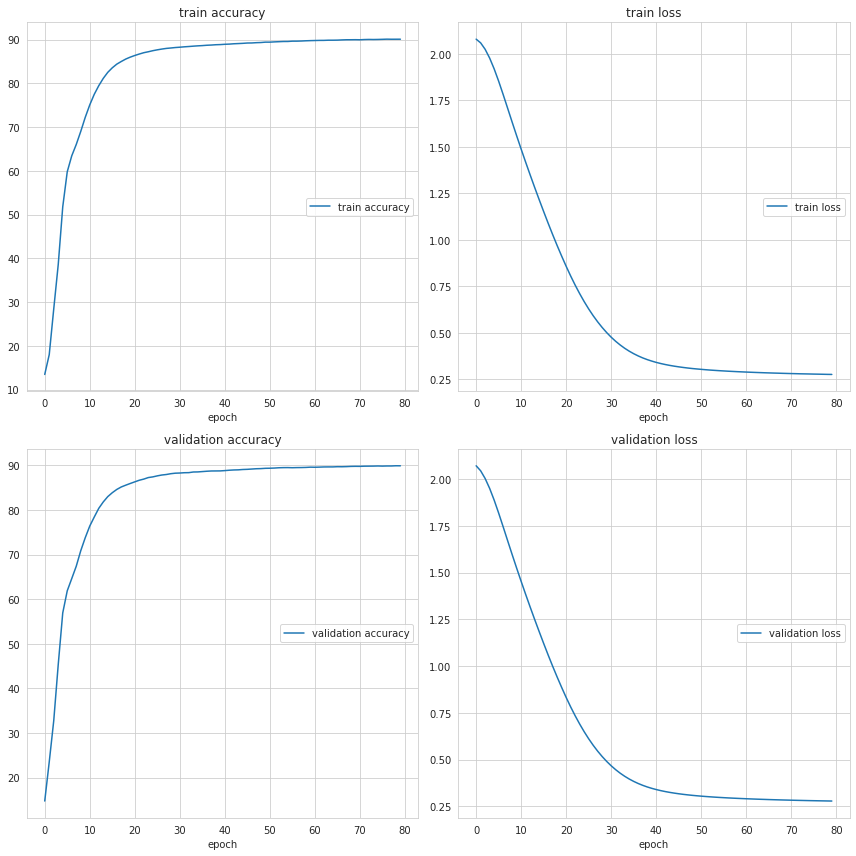

train accuracy
	train accuracy   	 (min:   13.451, max:   90.096, cur:   90.086)
train loss
	train loss       	 (min:    0.276, max:    2.080, cur:    0.276)
validation accuracy
	validation accuracy 	 (min:   14.733, max:   89.933, cur:   89.924)
validation loss
	validation loss  	 (min:    0.278, max:    2.072, cur:    0.278)


In [144]:
from livelossplot import PlotLosses
liveloss1_class = PlotLosses()
logs_class = {}
EPOCHS=80

for epoch in range(EPOCHS):
    print('starting epoch {}'.format(epoch))
    train_loss, train_acc = train_classify(model, trainloader, optimizer)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, EPOCHS, train_loss))
    
    print('Epoch {} of {}, Train Accuracy: {:.3f}'.format(
          epoch+1, EPOCHS, train_acc))
    
    logs_class['train loss'] = train_loss
    logs_class['train accuracy'] = train_acc

    valid_loss, valid_acc, label_list, pred_label_list  = evaluate_classify(model, validloader)
    print('Epoch {} of {}, Validate Loss: {:.3f}'.format(
        epoch+1, EPOCHS, valid_loss))
    
    print('Epoch {} of {}, Validate Accuracy: {:.3f}'.format(
        epoch+1, EPOCHS, valid_acc))

    logs_class['validation loss'] = valid_loss
    logs_class['validation accuracy'] = valid_acc
        
    liveloss1_class.update(logs_class)
    liveloss1_class.send()

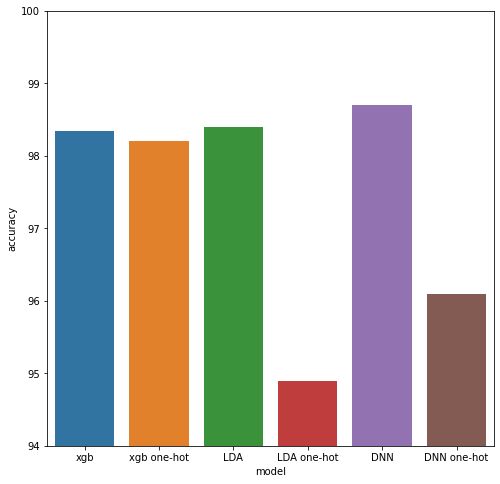

In [65]:
# plot accuracies
accuracy_dict = {'model': ['xgb', 'xgb one-hot', 'LDA', 'LDA one-hot', 'DNN', 'DNN one-hot'], 'accuracy': [accuracy_dictionary['xgBoost'], accuracy_dictionary['xgBoost_OneHot'], accuracy_dictionary["LDA"], accuracy_dictionary["LDA_OneHot"], 98.7, 96.1]}
accuracy_df = pd.DataFrame(accuracy_dict)
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x='model', y='accuracy', data=accuracy_df)
ax.set_ylim(94, 100)
plt.show()